In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import numpy as np
import os
import torch.nn as nn
from tqdm import tqdm
import json
from functools import partial
from torch import einsum, nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from einops import pack, rearrange, reduce, repeat, unpack


In [4]:
def findAllFile(base):
    file_path = []
    for root, ds, fs in os.walk(base, followlinks=True):
        for f in fs:
            fullname = os.path.join(root, f)
            file_path.append(fullname)
    return file_path



In [5]:
# from utils.motion_processing.hml_process import recover_from_ric, recover_root_rot_pos,recover_from_rot
import utils.vis_utils.plot_3d_global as plot_3d
import matplotlib.pyplot as plt

def vis(mot , dset , name = "motion"):

    if isinstance(mot , torch.Tensor):
        mot = dset.toMotion(mot)
    mot =dset.inv_transform(mot)



    xyz = np.array(dset.to_xyz(mot).cpu())

    print(xyz.shape)

    
    plot_3d.render(xyz , f"/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/{name}.gif")

In [10]:
all_mots = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/indices/body")

In [18]:
lenss = []
for i in tqdm(all_mots):
    lenss.append(np.load(i).shape[-1]/7.5)

100%|███████████████████████████████████| 80067/80067 [00:41<00:00, 1936.82it/s]


In [ ]:
7.5 1

In [19]:
data = lenss

In [25]:
print(mean - 1*std_dev, mean + 1*std_dev)

-20.112903063689025 37.939823018227095


In [45]:
mean

8.913459977269037

In [51]:
sum(np.array(data) < 4)

23950

In [52]:
sum(np.array(data)>4)

55362

(array([3.54959184e-02, 2.56499640e-04, 3.60461441e-04, 1.17581251e-04,
        4.53981664e-06, 2.26990832e-06, 4.53981664e-06, 3.58645515e-05,
        0.00000000e+00, 4.53981664e-07, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.53981664e-07, 4.53981664e-07, 9.07963329e-07,
        4.53981664e-07, 4.53981664e-07, 0.00000000e+00, 2.72388999e-06,
        2.72388999e-06, 2.17911199e-05, 2.67849182e-05, 7.26370663e-06,
        3.63185331e-06, 4.53981664e-07, 1.36194499e-06, 4.53981664e-07,
        4.53981664e-07, 4.53981664e-07]),
 array([1.33333333e-01, 2.76444444e+01, 5.51555556e+01, 8.26666667e+01,
        1.10177778e+02, 1.37688889e+02, 1.65200000e+02, 1.92711111e+02,
        2.20222222e+02, 2.47733333e+02, 2.75244444e+02, 3.02755556e+02,
        3.30266667e+02, 3.57777778e+02, 3.85288889e+02, 4.12800000e+02,
        4.40311111e+02, 4.67822222e+02, 4.95333333e+02, 5.22844444e+02,
        5.50355556e+02, 5.77866667e+02, 6.05377778e+02, 6.32888889e+02,
        6.60400000e+02

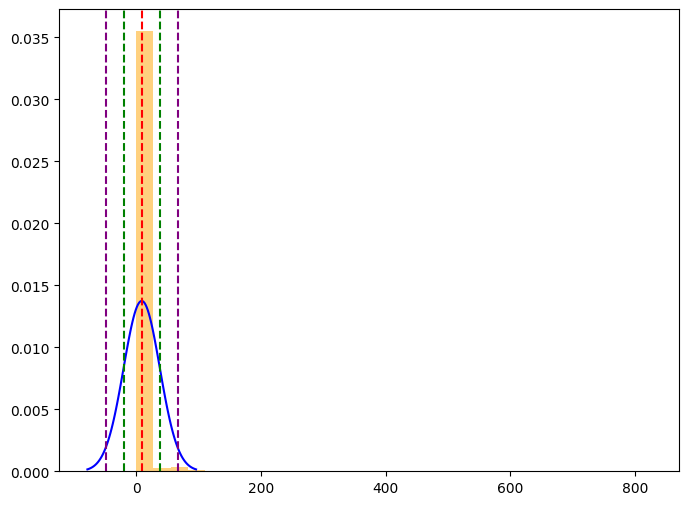

In [38]:
mean = np.mean(data)
std_dev = np.std(data)

# Create a range of x values
x_values = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)

# Calculate the probability density function (PDF) of the normal distribution
pdf = (1/(std_dev * np.sqrt(2*np.pi))) * np.exp(-0.5*((x_values - mean)/std_dev)**2)

# Plot the normal distribution
plt.figure(figsize=(8, 6))
plt.plot(x_values, pdf, color='blue', label='Normal Distribution')
plt.axvline(mean, color='red', linestyle='--', label='Mean')

# Draw standard deviation lines
plt.axvline(mean - std_dev, color='green', linestyle='--', label='Mean - 1 Std Dev')
plt.axvline(mean + std_dev, color='green', linestyle='--', label='Mean + 1 Std Dev')
plt.axvline(mean - 2*std_dev, color='purple', linestyle='--', label='Mean - 2 Std Dev')
plt.axvline(mean + 2*std_dev, color='purple', linestyle='--', label='Mean + 2 Std Dev')

plt.hist(data, bins=30, density=True, alpha=0.5, color='orange', label='Data Histogram')  # Plot histogram of data for comparison
# plt.title('Normal Distribution Plot')
# plt.xlabel('Values')
# plt.ylabel('Probability Density')
# plt.legend()
# plt.grid(True)
# plt.show()

In [7]:
# gen_cfg = strm_get_cfg_defaults()
# gen_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_streaming/motion_streaming.yaml")
# gen_cfg.freeze()

## VQVAE

In [11]:
from core.models.resnetVQ.vqvae import HumanVQVAE
from configs.config import cfg, get_cfg_defaults


In [12]:
def load_vqvae(gen_cfg):
    
    body_cfg = get_cfg_defaults()
    body_cfg.merge_from_file(gen_cfg.vqvae.body_config)
    left_cfg = get_cfg_defaults()
    left_cfg.merge_from_file(gen_cfg.vqvae.left_hand_config)
    right_cfg = get_cfg_defaults()
    right_cfg.merge_from_file(gen_cfg.vqvae.right_hand_config)
    # left_hand_model = HumanVQVAE(left_cfg.vqvae).to("cuda").eval()
    # left_hand_model.load(os.path.join(left_cfg.output_dir, "vqvae_motion.pt"))
    
    # right_hand_model = HumanVQVAE(right_cfg.vqvae).to("cuda").eval()
    # right_hand_model.load(os.path.join(right_cfg.output_dir, "vqvae_motion.pt"))
    
    body_model = HumanVQVAE(body_cfg.vqvae).to("cuda").eval()
    body_model.load(os.path.join(body_cfg.output_dir, "vqvae_motion.pt"))

    return body_model, body_cfg
    


## Motion Gen

In [34]:
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider, ConditionFuser
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.generation.motion_generator import Transformer, MotionMuse
from core.models.utils import instantiate_from_config, get_obj_from_str


In [35]:
from configs.config_t2m import cfg, get_cfg_defaults
from configs.config import get_cfg_defaults as get_cfg_defaults3

cfg = get_cfg_defaults()
cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_generation/motion_generation.yaml")
cfg.freeze()
mmuse_args = cfg.motion_generator
dataset_args = cfg.dataset


KeyError: 'Non-existent config key: motion_generator.fuse_method'

In [10]:
target = mmuse_args.pop("target")
motion_muse = MotionMuse(mmuse_args).to(device).eval()

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [11]:
from core.models.resnetVQ.vqvae import HumanVQVAE

In [12]:

vcfg = get_cfg_defaults3()
vcfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_body_gprvc/vqvae_body_gprvc.yaml")
vqvae_args = vcfg.vqvae
vqvae_args.nb_joints = 22
vqvae_args.motion_dim = 263

In [ ]:
np.split(np.cusum)

In [14]:
vqvae_model = HumanVQVAE(vqvae_args).to(device).eval()
vqvae_model.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ACMG/checkpoints/smplx_resnet/vqvae_motion.pt")

In [15]:
condition_provider = ConditionProvider(
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            audio_padding=dataset_args.audio_padding,
            motion_max_length_s=10,
            audio_max_length_s=10,
            pad_id = motion_muse.transformer.pad_token_id,
            fps=30/4
        )

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [16]:
# bod_ind = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/indices/body/aist/subset_0000/Dance_Break_3_Step_clip_1.npy")
# lh_ind = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/indices/left_hand/aist/subset_0000/Dance_Break_3_Step_clip_1.npy")
# rh_ind = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/indices/right_hand/aist/subset_0000/Dance_Break_3_Step_clip_1.npy")

In [18]:
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate

dset = MotionIndicesAudioTextDataset("animation" , "/srv/hays-lab/scratch/sanisetty3/motionx" ,motion_rep = "full", split = "train" , fps = 30/4  )

Total number of motions animation: 265 and texts 265


In [54]:
inpss  = next(iter(dset))

In [58]:
train_ds, sampler_train, weights_train  = load_dataset_gen(dataset_args=dataset_args, split = "train" , dataset_names = ["animation" , "choreomaster" ] )

Total number of motions animation: 73 and texts 73
Total number of motions choreomaster: 34 and texts 34


In [19]:
train_loader = torch.utils.data.DataLoader(
        dset,
        4,
        # sampler=sampler_train,
        # shuffle = False,
        collate_fn=partial(simple_collate , conditioner = condition_provider),
        drop_last=True,
    )

In [20]:
for inputs, conditions in train_loader:
    break
    

In [21]:
inputs["motion"][0].shape

torch.Size([4, 52, 3])

In [22]:
inputs["motion"][1].shape

torch.Size([4, 52])

In [23]:
conditions["audio"][0].shape

torch.Size([4, 1, 128])

In [24]:
conditions["text"][0].shape

torch.Size([4, 1, 768])

In [35]:
motions = inputs["motion"][0].squeeze().to(torch.long)
motion_mask = inputs["motion"][1]

In [164]:
fuse_method = {"cross": ["audio"], "prepend": ["text"]}
condition_fuser = ConditionFuser(fuse_method)

In [ ]:
audio_embed = self.project_audio(conditions["audio"][0])
text_embed = self.project_text(conditions["text"][0])

inputs_, cross_inputs = self.condition_fuser(
    input,
    {
        "text": (text_embed, conditions["text"][1]),
        "audio": (audio_embed, conditions["audio"][1]),
    },
)

## Muse gen

In [ ]:


def bkn_to_motion(codes, dset):
        # codes b k n
        body_inds = codes[:, 0]
    
        body_motion = body_model.decode(body_inds[0:1]).detach().cpu()
        
        body_M = dset.toMotion(
            body_motion[0],
            motion_rep=MotionRep(body_cfg.dataset.motion_rep),
            hml_rep=body_cfg.dataset.hml_rep,
        )
        

        return body_M

ds, _, _  = load_dataset_gen(dataset_names = ["animation"] , dataset_args=dataset_args, split = "render")


In [ ]:
motion_gen = MotionMuse(tranformer_config , fuse_config , pattern_config).to(device)
# pkg = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse/motion_muse.pt", map_location="cuda")
# motion_gen.load_state_dict(pkg["model"])

In [ ]:
# _, conditions = condition_provider(raw_audio= raw_audio2)
_, conditions = condition_provider(raw_audio= None, raw_text="a person doing kung fu kick and then jumping")
_, neg_conditions = condition_provider(raw_text="turning around")
gen_ids = motion_gen.generate(conditions =conditions, neg_conditions = None, duration_s = 30, temperature = 0.2 ,timesteps=18, cond_scale = 8)
gen_motion = bkn_to_motion(gen_ids, ds.datasets[0])
ds.datasets[0].render_hml(
                    gen_motion,
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/gen_novel.gif"
                )

## MotionMuse

In [6]:
from core import MotionTokenizerParams, pattern_providers

from core.param_dataclasses import pattern_providers
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.utils import instantiate_from_config, get_obj_from_str
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider,ConditionFuser
from core.models.generation.muse import MLMModel, MotionMuse
import einops
from configs.config_t2m import get_cfg_defaults as muse_get_cfg_defaults

from core.datasets.text_encoders import BERTConditioner, ClipConditioner, T5Conditioner, parse_prompt_attention
from core.datasets.audio_encoders import EncodecConditioner, LibrosaConditioner

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
gen_cfg = muse_get_cfg_defaults()
gen_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse_constant/motion_muse_constant.yaml")
gen_cfg.freeze()

In [8]:
tranformer_config = gen_cfg.motion_generator
fuse_config = gen_cfg.fuser
pattern_config = gen_cfg.codebooks_pattern
dataset_args = gen_cfg.dataset

target = tranformer_config.pop("target")


In [9]:
motion_gen = MotionMuse(tranformer_config , fuse_config , pattern_config).to(device)
# pkg = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse/motion_muse.pt", map_location="cuda")
# motion_gen.load_state_dict(pkg["model"])

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [10]:
dataset_args

CfgNode({'dataset_name': 'mix', 'dataset_root': '/srv/hays-lab/scratch/sanisetty3/motionx', 'music_folder': 'music', 'fps': 30, 'down_sampling_ratio': 4, 'text_rep': 'pooled_text_embed', 'motion_rep': 'body', 'hml_rep': 'rv', 'audio_rep': 'clap', 'motion_min_length_s': 2, 'motion_max_length_s': 4, 'audio_max_length_s': 4, 'window_size_s': 4, 'sampling_rate': 16000, 'text_conditioner_name': 'laion/larger_clap_music_and_speech', 'audio_padding': 'max_length', 'motion_padding': 'max_length'})

In [11]:
condition_provider = ConditionProvider(
            text_conditioner_name = dataset_args.text_conditioner_name,
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            audio_padding=dataset_args.audio_padding,
            motion_max_length_s=dataset_args.motion_max_length_s,
            audio_max_length_s=dataset_args.audio_max_length_s,
            pad_id = motion_gen.model.pad_token_id,
            fps=30/4,
            # device = "cpu"
        )

In [35]:
train_ds, sampler_train, weights_train  = load_dataset_gen(dataset_names = ["aist" , "animation" , "choreomaster"] , dataset_args=dataset_args, split = "train")


Total number of motions aist: 1142 and texts 1142
Total number of motions animation: 120 and texts 120
Total number of motions choreomaster: 34 and texts 34


In [46]:
train_loader = torch.utils.data.DataLoader(
        train_ds,
        4,
        sampler=sampler_train,
        # shuffle = False,
        collate_fn=partial(simple_collate , conditioner = condition_provider , permute = True),
        # drop_last=True,
    )

In [47]:
for inputs, conditions in train_loader:
    break
    

In [48]:
inputs["names"]

array(['choreomaster/1033',
       'animation/subset_0003/Ways_To_Text_Faking_It',
       'animation/subset_0004/Ways_To_Wake_Up_Where_Am_I',
       'choreomaster/1172'], dtype='<U48')

In [49]:
conditions["audio"][0].shape

torch.Size([4, 1, 512])

In [50]:
conditions["text"][0].shape

torch.Size([4, 1, 512])

In [51]:
inputs["motion"][0].shape

torch.Size([4, 1, 30])

In [13]:
input_mask = inputs["motion"][1]
motions_ids = inputs["motion"][0].cuda()
B, K, T = motions_ids.shape

In [14]:
motions_ids.shape

torch.Size([4, 1, 75])

In [15]:
seq_len = T

In [16]:
shape = (B,K , T)

ids = torch.full(shape, motion_gen.mask_token_id, dtype=torch.long, device=device)
mask = torch.ones_like(ids).to(torch.bool)
scores = torch.zeros(shape, dtype=torch.float32, device=device)

In [17]:
timestep = torch.zeros(1)

In [18]:
rand_mask_prob = motion_gen.noise_schedule(timestep)
num_token_masked = max(
                int((rand_mask_prob * seq_len * motion_gen.num_codeboks).item()), 1
            )

In [19]:
num_token_masked

75

In [20]:
masked_indices = scores.topk(num_token_masked, dim=-1).indices

In [21]:
masked_indices

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
          34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
          51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
          68, 69, 70, 71, 72, 73, 74]],

        [[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
          34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
          51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
          68, 69, 70, 71, 72, 73, 74]],

        [[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
          34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
          51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63

In [22]:
ids = ids.scatter(-1, masked_indices, motion_gen.mask_token_id)

In [23]:
ids.shape

torch.Size([4, 1, 75])

In [26]:
ignore_index = -100

In [27]:
motions_ids.shape

torch.Size([4, 1, 75])

In [47]:
x, labels = motion_gen.bert_muse_mask(motions_ids, ignore_index)

In [20]:
loss , logits = motion_gen(inputs["motion"] , conditions, return_logits=True)

In [21]:
loss

tensor(6.4272, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [48]:
x[0 , : , :10]

tensor([[513, 513,  18, 513, 513, 513, 513, 513, 392, 513],
        [513, 492, 513, 513, 513, 513, 395, 513, 513, 513],
        [513, 513, 513, 513, 513, 513, 513,  18, 513, 513]], device='cuda:0')

In [49]:
labels[0 , : , :10]

tensor([[218, 454,  18, 357, 477, 264, 174, 174,  18, 334],
        [129, 492, 203, 134, 288, 451, 451, 190, 325, 325],
        [347, 176, 498, 408, 113, 459, 445,  18, 322, 280]], device='cuda:0')

In [50]:
motions_ids[0 , : , :10]

tensor([[218, 454,  18, 357, 477, 264, 174, 174,  18, 334],
        [129, 492, 203, 134, 288, 451, 451, 190, 325, 325],
        [347, 176, 498, 408, 113, 459, 445,  18, 322, 280]], device='cuda:0')

In [36]:
loss , logits = motion_muse((motions , motion_mask) , conditions , cond_drop_prob = 0.4 , return_logits = True)

In [79]:
pred_indices = lologits.argmax(-1)
pred_motion  = vqvae_model.decode(pred_indices[:1])

In [65]:
mod_motion = torch.where(motions >= 1024 , 0 , motions)
gt_motion  = vqvae_model.decode(mod_motion)

In [66]:
dset.render_hml(
                    gt_motion[1][:(int(sum(motion_mask[1])) *4)].detach().squeeze().cpu(),
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/gt_motion_recon.gif"
                )

In [ ]:
logits2 = motion_muse.transformer.forward_with_cond_scale((motions , motion_mask) , conditions)
logits3 =motion_muse.transformer.forward_with_neg_prompt((motions , motion_mask) , conditions , conditions)

In [48]:
motions.shape

torch.Size([4, 28])

In [49]:
28*4

112

100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 14.65it/s]


## Streaming transformer

In [15]:

from core.param_dataclasses import pattern_providers
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.utils import instantiate_from_config, get_obj_from_str


In [16]:
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider,ConditionFuserStreamer
from core.models.generation.lm import LMModel, MotionGen
import einops

In [8]:
gen_cfg = strm_get_cfg_defaults()
gen_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_streaming/motion_streaming.yaml")
gen_cfg.freeze()

In [9]:
lm_args = gen_cfg.transformer_lm
target = lm_args.pop("target")
fuse_config = gen_cfg.fuser
pattern_args = gen_cfg.codebooks_pattern
dataset_args = gen_cfg.dataset

In [10]:
model_gen= MotionGen(lm_args , fuse_config , pattern_args ).to(device)
model_gen = model_gen.eval()

In [64]:
modeling = pattern_args.pop("modeling")
pattern_provider = pattern_providers[modeling](lm_args.n_q, delays = pattern_args.delays , flatten_first = pattern_args.flatten_first , empty_initial = pattern_args.empty_initial )

In [65]:
fuse_method = fuse_config.pop("fuse_method")


In [66]:
fuse_method = {'cross': ['text'], 'input_interpolate': ['audio']}

In [68]:
if isinstance(fuse_method, list):
    fuse_method = fuse_method[0]
condition_fuser = ConditionFuserStreamer(fuse_method, **fuse_config)

In [69]:
model = LMModel(
            pattern_provider=pattern_provider,
            fuser=condition_fuser,
            **lm_args
        ).to(device)

In [11]:
condition_provider = ConditionProvider(
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            audio_padding=dataset_args.audio_padding,
            motion_max_length_s=10,
            audio_max_length_s=10,
            pad_id = model_gen.model.pad_token_id,
            fps=30/4,
            # device = "cpu"
        )

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [12]:
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
# dset = MotionIndicesAudioTextDataset("beat" , "/srv/hays-lab/scratch/sanisetty3/motionx" ,motion_rep = "full", split = "render" , fps = 30/4  )


In [37]:
train_ds, sampler_train, weights_train  = load_dataset_gen(dataset_names = ["humanml"] , dataset_args=dataset_args, split = "test")
train_loader = torch.utils.data.DataLoader(
        train_ds,
        1,
        # sampler=sampler_train,
        # shuffle = False,
        collate_fn=partial(simple_collate , conditioner = condition_provider , permute = True),
        # drop_last=True,
    )

min length 23
Total number of motions humanml: 9852 and texts 9852


In [ ]:
for inputs, conditions in train_loader:
    break
    

In [38]:
train_ds.datasets[0].fps

7.5

In [39]:
for inputs, conditions in train_loader:
    input_mask = inputs["motion"][1]
    motions_or_ids = inputs["motion"][0]
    if motions_or_ids.shape[-1] < 1: 
        print(input_mask.shape , motions_or_ids.shape )
    

before (74,) 0 0 (0, 0)
after (74,)
in collate (74, 3)
before (74,) 0 0 (0, 0)
after (74,)
in collate (74, 3)
before (74,) 0 0 (0, 0)
after (74,)
in collate (74, 3)
before (42,) 0 0 (0, 0)
after (42,)
in collate (42, 3)
before (42,) 0 0 (0, 0)
after (42,)
in collate (42, 3)
before (42,) 0 0 (0, 0)
after (42,)
in collate (42, 3)
before (74,) 0 0 (0, 0)
after (74,)
in collate (74, 3)
before (74,) 0 0 (0, 0)
after (74,)
in collate (74, 3)
before (74,) 75 7 (563, 52)
after (67,)
in collate (67, 3)
before (74,) 0 0 (0, 0)
after (74,)
in collate (74, 3)
before (74,) 0 0 (0, 0)
after (74,)
in collate (74, 3)
before (74,) 0 0 (0, 0)
after (74,)
in collate (74, 3)
before (26,) 0 0 (0, 0)
after (26,)
in collate (26, 3)
before (26,) 0 0 (0, 0)
after (26,)
in collate (26, 3)
before (26,) 0 0 (0, 0)
after (26,)
in collate (26, 3)
before (74,) 0 0 (0, 0)
after (74,)
in collate (74, 3)
before (74,) 0 0 (0, 0)
after (74,)
in collate (74, 3)
before (74,) 0 0 (0, 0)
after (74,)
in collate (74, 3)
before

Traceback (most recent call last):
  File "/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3505199/2339001282.py", line 1, in <module>
    for inputs, conditions in train_loader:
  File "/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data = self._next_data()
  File "/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 675, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/coc/scratch/sanisetty3/music_motion/ATCMG/core/datasets/multimodal_datase

In [27]:
inputs["names"]

array(['animation/subset_0002/Ways_To_Open_A_Christmas_Gift_Shaking'],
      dtype='<U59')

In [42]:
input_mask = inputs["motion"][1]
motions_or_ids = inputs["motion"][0].cuda()
B, K, T = motions_or_ids.shape

In [28]:
motions = inputs["motion"][0].squeeze().to(torch.long)
motion_mask = inputs["motion"][1]


In [29]:
motions.shape

torch.Size([3, 72])

In [99]:
conditions["text"][0].shape

torch.Size([4, 24, 768])

In [100]:
conditions["audio"][0].shape

torch.Size([4, 300, 128])

In [101]:
conditions["audio"][1]

tensor([[False, False, False,  ..., False, False, False],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]], device='cuda:0')

In [103]:
cond = conditions["audio"][0]
cond_mask = conditions["audio"][1]
cond = einops.rearrange(cond, "b t d -> b d t")
cond = F.interpolate(cond, size=52)
cond_mask = (
    F.interpolate(
        cond_mask.unsqueeze(1).to(torch.float),
        size=52,
    )
    .squeeze(1)
    .to(torch.bool)
)

In [105]:
out = model_gen((motions, motion_mask), conditions)

In [33]:
B , N , C = conditions["audio"][0].shape

In [84]:
out = model.compute_predictions(inputs["motion"] , conditions)

In [38]:
audio_embed = model.project_audio(conditions["audio"][0])
text_embed = model.project_text(conditions["text"][0])

In [39]:
audio_embed.shape

torch.Size([4, 500, 512])

In [43]:
input_ = sum([model.emb[k](motions_or_ids[:, k]) for k in range(K)])

In [85]:
motions.shape

torch.Size([4, 3, 52])

## VIusalise motions

In [42]:
def bkn_to_motion(codes, dset):
        # codes b k n
        body_inds = codes[:, 0]
        left_inds = codes[:, 1]
        right_inds = codes[:, 2]
        body_motion = body_model.decode(body_inds[0:1]).detach().cpu()
        left_motion = left_hand_model.decode(left_inds[0:1]).detach().cpu()
        right_motion = right_hand_model.decode(right_inds[0:1]).detach().cpu()
        body_M = dset.toMotion(
            body_motion[0],
            motion_rep=MotionRep(body_cfg.dataset.motion_rep),
            hml_rep=body_cfg.dataset.hml_rep,
        )
        left_M = dset.toMotion(
            left_motion[0],
            motion_rep=MotionRep(left_cfg.dataset.motion_rep),
            hml_rep=left_cfg.dataset.hml_rep,
        )
        right_M = dset.toMotion(
            right_motion[0],
            motion_rep=MotionRep(right_cfg.dataset.motion_rep),
            hml_rep=right_cfg.dataset.hml_rep,
        )
        full_M = dset.to_full_joint_representation(body_M, left_M, right_M)

        return full_M

In [28]:
for inputs, conditions in train_loader:
    break
    

In [20]:
dset = train_ds.datasets[0]

In [ ]:
body_inds = motions_or_ids[:,0]
left_inds = motions_or_ids[:,1]
right_inds = motions_or_ids[:,2]
body_motion = body_model.decode(body_inds[0:1]).detach()
left_motion = left_hand_model.decode(left_inds[0:1]).detach()
right_motion = right_hand_model.decode(right_inds[0:1]).detach()
body_M = dset.toMotion(body_motion[0] , motion_rep = MotionRep(body_cfg.dataset.motion_rep) , hml_rep = body_cfg.dataset.hml_rep , )
left_M = dset.toMotion(left_motion[0] , motion_rep = MotionRep(left_cfg.dataset.motion_rep) , hml_rep = left_cfg.dataset.hml_rep , )
right_M = dset.toMotion(right_motion[0] , motion_rep = MotionRep(right_cfg.dataset.motion_rep) , hml_rep = right_cfg.dataset.hml_rep , )
full_M = dset.to_full_joint_representation(body_M , left_M , right_M )

In [38]:
motion.device

device(type='cuda', index=0)

In [41]:
motion = inputs["motion"][0]

In [42]:
gt_motion = bkn_to_motion(motion, dset)

In [47]:
gt_motion.velocity.shape

torch.Size([288, 156])

In [39]:
# dset.render_hml(gt_motion , "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/full_joined.gif", from_rotation = True)

In [33]:
inputs["motion"][0].shape

torch.Size([1, 1, 75])

In [ ]:
body_inds = motions_or_ids[:,0]
body_motion = body_model.decode(body_inds[0:1]).detach()
body_M = dset.toMotion(body_motion[0] , motion_rep = MotionRep(body_cfg.dataset.motion_rep) , hml_rep = body_cfg.dataset.hml_rep , )


In [44]:
for inputs, conditions in tqdm(train_loader):
    # print(inputs["names"][0])
    
    motion = inputs["motion"][0][...,:300]
    gt_motion = bkn_to_motion(motion, dset)
    # body_inds = motion[:,0]
    # with torch.no_grad():
    #     body_motion = body_model.decode(body_inds[0:1]).cpu()
    # body_M = dset.toMotion(body_motion[0] , motion_rep = MotionRep(body_cfg.dataset.motion_rep) , hml_rep = body_cfg.dataset.hml_rep , )

    dset.render_hml(gt_motion , f"/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/all/{os.path.basename(inputs['names'][0])}.gif", from_rotation = True)
    


  0%|                                                                                                 | 0/32 [00:00<?, ?it/s]

animation/subset_0002/Ways_To_Open_A_Christmas_Gift_Shaking


  3%|██▊                                                                                      | 1/32 [00:26<13:52, 26.86s/it]

animation/subset_0000/Ways_To_Catch_A_Cold


  6%|█████▌                                                                                   | 2/32 [00:35<08:12, 16.43s/it]

humanml/012698


  9%|████████▎                                                                                | 3/32 [01:03<10:19, 21.35s/it]

humanml/012698


 12%|███████████▏                                                                             | 4/32 [01:30<11:06, 23.79s/it]

humanml/012698


 16%|█████████████▉                                                                           | 5/32 [01:57<11:12, 24.92s/it]

humanml/005095


 19%|████████████████▋                                                                        | 6/32 [02:06<08:28, 19.54s/it]

humanml/005095


 22%|███████████████████▍                                                                     | 7/32 [02:15<06:43, 16.12s/it]

humanml/005095


 25%|██████████████████████▎                                                                  | 8/32 [02:24<05:32, 13.86s/it]

perform/subset_0002/Wash_Clothes_clip_8


 28%|█████████████████████████                                                                | 9/32 [02:35<04:56, 12.91s/it]

perform/subset_0002/Take_Off_Cloth_clip_3


 31%|███████████████████████████▌                                                            | 10/32 [03:02<06:21, 17.33s/it]

GRAB/s7/train_pass_1


 34%|██████████████████████████████▎                                                         | 11/32 [03:22<06:19, 18.07s/it]

GRAB/s4/piggybank_pass_1


 38%|█████████████████████████████████                                                       | 12/32 [03:37<05:44, 17.22s/it]

idea400/subset_0040/Sitting_While_Cycling


 41%|███████████████████████████████████▊                                                    | 13/32 [03:51<05:07, 16.17s/it]

idea400/subset_0056/Walking_And_Snapping_At_The_Same_Time


 44%|██████████████████████████████████████▌                                                 | 14/32 [04:12<05:18, 17.72s/it]

humman/subset_0005/Skating_Ice_Skater_clip_1


 47%|█████████████████████████████████████████▎                                              | 15/32 [04:31<05:04, 17.89s/it]

beat/7_sophie_0_67_67


 50%|████████████████████████████████████████████                                            | 16/32 [04:59<05:36, 21.04s/it]

game_motion/subset_0028/Shield_Drei_clip_8


 53%|██████████████████████████████████████████████▊                                         | 17/32 [05:13<04:42, 18.85s/it]

game_motion/subset_0006/Emotion_Beginning


 56%|█████████████████████████████████████████████████▌                                      | 18/32 [05:31<04:20, 18.62s/it]

music/subset_0015/Play_Bass_Drum_clip_27


 59%|████████████████████████████████████████████████████▎                                   | 19/32 [05:44<03:42, 17.09s/it]

music/subset_0011/Play_Three-stringed_Plucked_Instrument_clip_32


 62%|███████████████████████████████████████████████████████                                 | 20/32 [05:55<03:02, 15.19s/it]

aist/subset_0009/Dance_Pop_Hand_Wave_clip_4


 66%|█████████████████████████████████████████████████████████▊                              | 21/32 [06:18<03:12, 17.47s/it]

fitness/subset_0066/Single_To_Double_Butt_Kick_clip_3


 69%|████████████████████████████████████████████████████████████▌                           | 22/32 [06:45<03:24, 20.44s/it]

fitness/subset_0053/Romanian_Deadlift_clip_3


 72%|███████████████████████████████████████████████████████████████▎                        | 23/32 [07:12<03:21, 22.36s/it]

moyo/220923_yogi_body_hands_03596_Cat_Cow_Pose_or_Marjaryasana_-b_stageii


 75%|██████████████████████████████████████████████████████████████████                      | 24/32 [07:32<02:52, 21.58s/it]

moyo/220923_yogi_body_hands_03596_Locust_Pose_or_Salabhasana_-b_stageii


 78%|████████████████████████████████████████████████████████████████████▊                   | 25/32 [07:58<02:39, 22.80s/it]

choreomaster/1074


 81%|███████████████████████████████████████████████████████████████████████▌                | 26/32 [08:26<02:27, 24.50s/it]

choreomaster/1010


 84%|██████████████████████████████████████████████████████████████████████████▎             | 27/32 [08:54<02:07, 25.57s/it]

dance/subset_0000/A_Hundred_Dances


 88%|█████████████████████████████████████████████████████████████████████████████           | 28/32 [09:22<01:44, 26.10s/it]

kungfu/subset_0002/Shaolin_Kung_Fu_Wushu_Basic_Stretching_Training_To_Kick_Higher_clip_10


 91%|███████████████████████████████████████████████████████████████████████████████▊        | 29/32 [09:49<01:19, 26.43s/it]

kungfu/subset_0002/Kung_Fu_Wushu_Butterfly_Kick_Bkick_clip_9


 94%|██████████████████████████████████████████████████████████████████████████████████▌     | 30/32 [10:16<00:53, 26.59s/it]

EgoBody/recording_20220315_S30_S21_02/body_idx_0/001


 97%|█████████████████████████████████████████████████████████████████████████████████████▎  | 31/32 [10:44<00:27, 27.09s/it]

EgoBody/recording_20220218_S02_S23_01/body_idx_1/000


100%|████████████████████████████████████████████████████████████████████████████████████████| 32/32 [11:12<00:00, 21.02s/it]


In [62]:
body_M.hml_rep

'rv'

In [100]:
choreo = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/choreomaster/1160.npy")
full_og = dset.toMotion(choreo , motion_rep = MotionRep("full") , hml_rep = "gprvc" )
xyz = dset.to_xyz(full_og, from_rotation=True).cpu()

In [104]:
import utils.vis_utils.plot_3d_global as plot_3d
plot_3d.render(
            np.array(xyz)[:300],
            "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/full_og.gif",
        )

In [102]:
choreo.shape

(6466, 623)

In [105]:
full_M = dset.inv_transform(full_M)
full_M.tensor()
full_M.root_params = full_og.root_params[:full_M.rotations.shape[0]]
xyz_ = dset.to_xyz(full_M, from_rotation=True).cpu()

In [106]:
xyz_.shape

torch.Size([6448, 52, 3])

In [107]:

plot_3d.render(
            np.array(xyz_)[:300],
            "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/full_joined.gif",
        )

In [48]:
null_conditions = model.cfg_dropout(conditions, 1.0)

In [43]:
out = model.compute_predictions(inputs["motion"] , conditions)

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [45]:
model = model.eval()

In [49]:
outt = model.generate(conditions = null_conditions , two_step_cfg =True)

In [50]:
outt.shape

torch.Size([4, 3, 225])

In [23]:
import time
start = time.time()
for i in range(10):
    outt = model.generate(conditions = conditions , two_step_cfg =True)
end = time.time()
print('custom attention took {} seconds'.format(end - start))

custom attention took 31.624648332595825 seconds


In [26]:
import time
start = time.time()
for i in range(10):
    outt = model.generate(conditions = conditions , two_step_cfg =True)
end = time.time()
print('custom attention without flash took {} seconds'.format(end - start))

custom attention without flash took 34.69120717048645 seconds


In [41]:
import time
start = time.time()
for i in range(10):
    outt = model.generate(conditions = conditions , two_step_cfg =True)
end = time.time()
print('torch attention took {} seconds'.format(end - start))

torch attention took 22.785192251205444 seconds


In [35]:
model_cfg = cfg_s.transformer_lm

In [36]:
params = MotionTokenizerParams(model_cfg.card)

In [104]:
n_q = 3
codes = inputs["motion"][0].permute(0,2,1).to(torch.long)
code_mask = inputs["motion"][1]

In [105]:
B, K, T = codes.shape
codes = codes.contiguous()

In [106]:
codes.shape

torch.Size([4, 52, 3])

In [1]:
pattern = pattern_provider.get_pattern(T)

NameError: name 'pattern_provider' is not defined

In [108]:
pattern

Pattern(layout=[[], [LayoutCoord(t=0, q=0)], [LayoutCoord(t=1, q=0), LayoutCoord(t=0, q=1), LayoutCoord(t=0, q=2)], [LayoutCoord(t=2, q=0), LayoutCoord(t=1, q=1), LayoutCoord(t=1, q=2)], [LayoutCoord(t=3, q=0), LayoutCoord(t=2, q=1), LayoutCoord(t=2, q=2)]], timesteps=3, n_q=3)

In [46]:
sequence_codes, sequence_indexes, sequence_mask = (
            pattern.build_pattern_sequence(
                codes,
                1025,
                keep_only_valid_steps=True,
            )
)

In [48]:
sequence_codes.shape

torch.Size([4, 3, 53])

In [47]:
code_mask.shape

torch.Size([4, 52])

In [49]:
sequence_mask.shape

torch.Size([3, 53])

In [50]:
new_mask = torch.ones_like(sequence_mask).repeat(B , 1 , 1)
for i in range(n_q):
    new_mask[:,i,i+1:] = code_mask[:,0:T-i]

In [53]:
new_mask.shape

torch.Size([4, 3, 53])

In [56]:
new_new_mask = (new_mask.sum(1) == new_mask.shape[1])

In [59]:
new_new_mask[0]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False])

In [6]:
from core.datasets.audio_encoders import EncodecConditioner

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
audio_list = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/")

In [8]:
audenc = EncodecConditioner(target_sr = 9600)
# audlib = AudioConditionerLibrosa()

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [20]:
for src in tqdm(audio_list):
    embs = audenc(audio_list[0])
    np.save(src.replace("/wav" , "/encodec").replace(".wav" , ".npy") , embs.detach().cpu().numpy())

100%|████████████████████████████████████████████████████████████████████████████████████| 1724/1724 [07:27<00:00,  3.85it/s]


In [19]:
audio_list[0]

'/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/aist/mJS5.wav'

In [15]:
emb = audenc(audio_list[0])

In [16]:
emb.shape

torch.Size([887, 128])

In [17]:
np.load("/srv/hays-lab/scratch/sanisetty3/motionx/audio/encodec/aist/mBR0.npy").shape

(2700, 128)

In [40]:
emb = audenc("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/choreomaster/0071.wav")

In [50]:
emb2 = audlib("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/choreomaster/0071.wav")

In [51]:
emb2.shape

(5234, 35)

In [52]:
emb.shape

torch.Size([8722, 128])

In [53]:
emb1 = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/audio/encodec/choreomaster/0071.npy")

In [54]:
emb1.shape

(8722, 128)